In [1]:
import util.ml_util as ut
from sklearn import linear_model
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import h2o
import numpy as np
from h2o.automl import H2OAutoML
import sklearn
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

<h2> Models </h2>
Firstly, we define the different models to use for the tests. 
These are defined in a function, in order to create new models for every tests. If not, we reuse the parameters from previous training processes.
The models are:

- Linear model: Ridge Regression from sklearn
- Neural network model: implemented in pytorch
- Distributed random forest model: Implemented in autoML for best results



In [2]:
column_names = ['Temperature',  'Salinity', 'u_east', 'v_north',  'w_north', 'w_east', 'depth' ,'Temperature gradient', \
     'Salinity gradient','w_east_gradient', 'u_east gradient','v_north_gradient','w_north_gradient','depth_gradient','Calanus finmarchicus', \
        'Calanus finmarchicus gradient', 'Catch']
class simpleNet(nn.Module):
    def __init__(self, input_shape):
        super(simpleNet, self).__init__()
        self.fc1 = nn.Linear(input_shape, input_shape*10)
        self.fc2 = nn.Linear(input_shape*10, input_shape)
        self.fc3 = nn.Linear(input_shape, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

def train_net(model, trainloader,loss_fn, epochs=80, lr = .01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(epochs):
        for j,(x_train,y_train) in enumerate(trainloader):
            
            #calculate output
            output = model(x_train)
            #if j == 0:print(output)
            #calculate loss
            #plt.hist(output.detach().numpy())
            loss = loss_fn(output,y_train.reshape(-1,1))
        
            #accuracy
            #predicted = model(torch.tensor(jan_2019_data,dtype=torch.float32))
            #acc = (predicted.reshape(-1).detach().numpy().round() == jan_2019_target).mean()
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def get_models(x, y,n_vars = 16, verbose = False):

    #make and train linear model
    linmod =  linear_model.RidgeClassifier()
    linmod.fit(x,y)
    if verbose: print('Linear model fitted')
    #make and train neural network model
    nnmod = simpleNet(n_vars)
    trainset = dataset(x,y)
    trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
    #train nn model
    train_net(nnmod, trainloader=trainloader, loss_fn=nn.BCELoss())
    if verbose: print('Neural network trained')
    #h2o.init()
    #make and train h2o DRF
    amlmod = h2o.estimators.H2ORandomForestEstimator( seed=1,balance_classes=True)
    training = np.append(x, np.expand_dims(y,1), axis=1)
    train = h2o.H2OFrame(training,column_names =column_names)
    train['Catch'] = train['Catch'].asfactor()
    #train drf model
    amlmod.train(x=column_names[:16], y='Catch',training_frame=train)
    if verbose: print('DRF calculated')

    return linmod, nnmod, amlmod


<h2> Validation </h2>
Now, we define the validation of the models. They are validated based on 3 metrics: sensitivity, specificity, and accuracy. In addition to this, a visual may be plotted to visually evaluate model prediction.

In [3]:

def validate_models(models, x,y, show_plot=False,cutoff = .5):
    for model in models:
        print("Validation metrics for model: ", type(model))
        if isinstance(model, h2o.estimators.H2ORandomForestEstimator):
            #print('testing model:', type(model), "as drf automl")
            test = np.append(x, np.expand_dims(y,1), axis=1)
            test = h2o.H2OFrame(test,column_names =column_names)
            test['Catch'] = test['Catch'].asfactor()
            
            #pred = np.reshape(model.predict(test)[:,0], (-1,1))
            pred = model.predict(test).as_data_frame().to_numpy()
            #print(pred.shape)
            pred = pred[...,0:1]
            #print(pred.shape)
           # print(len(pred[0]))
        elif isinstance(model, simpleNet): 
            #print('testing model:', type(model), 'as network')
            test = torch.tensor(x, dtype=torch.float32)
            pred = model(test).detach().numpy()
            pred = np.array([1 if p > cutoff else 0 for p in pred])
        else:
            #print('testing model:', type(model), 'as linear classifier')
            test = x
            pred = model.predict(test)
        ut.validate(model, pred, y,cutoff=cutoff, show_plot=show_plot)


def test_partition(X_train, X_test, Y_train, Y_test,show_plot =False ):
    '''
    Makes models and trains them. Also scales data 
    '''
    sc = sklearn.preprocessing.StandardScaler()
    undersample = RandomUnderSampler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    Y_train = np.array([1 if item > 0 else 0 for item in Y_train])
    Y_test = np.array([1 if item > 0 else 0 for item in Y_test])
    X_test, Y_test = undersample.fit_resample(X_test, Y_test)
    X_train, Y_train = undersample.fit_resample(X_train, Y_train)
    (lin, NN, drf) = get_models(X_train, Y_train,X_train.shape[1])
    validate_models((lin, NN , drf), X_test, Y_test,show_plot)


<h2> Data loading </h2>
Now it is time to load the data. The function 'load_and_combine_data' only provides raw data, it is up to us to scale and transform the data to its proper format in order to do prediction.

First, we test the models on dataset 1 (find closes grid cell when data missing) and dataset 2 (skip data point when data missing)

In [4]:
folder = 'dataset_2_skip_bad_cells'
jan_2019_data, jan_2019_target = ut.load_and_combine_data(2019, 'jan',folder)
jan_2020_data, jan_2020_target = ut.load_and_combine_data(2020, 'jan',folder)
jan_2021_data, jan_2021_target = ut.load_and_combine_data(2021, 'jan',folder)
dec_2020_data, dec_2020_target = ut.load_and_combine_data(2020, 'dec',folder)
dec_2019_data, dec_2019_target = ut.load_and_combine_data(2019, 'dec',folder)
dec_2021_data, dec_2021_target = ut.load_and_combine_data(2021, 'dec',folder)

sc = sklearn.preprocessing.StandardScaler()
oversample = RandomOverSampler()
undersample = RandomUnderSampler()

#h2o.shutdown()
#h2o.init()

#all_data = np.concatenate((jan_2019_data,dec_2019_data, jan_2020_data, dec_2020_data, jan_2021_data, dec_2021_data), axis=0)
#all_data = sc.fit_transform(all_data)
#jan = np.concatenate((jan_2019_data, jan_2020_data, jan_2021_data), axis=0)
all_data_except_jan_2021 = np.concatenate((dec_2019_data,  dec_2020_data, dec_2021_data), axis=0)
#all_target = np.concatenate((jan_2019_target, dec_2019_target, jan_2020_target,dec_2020_target, jan_2021_target, dec_2021_target),axis=0)
#all_target = np.array([1 if item > 0 else 0 for item in all_target]) #create classification problem
#all_data, all_target = undersample.fit_resample(all_data, all_target)
jan_target = np.concatenate((jan_2019_target, jan_2020_target, jan_2021_target),axis=0)
jan_target = np.array([1 if item > 0 else 0 for item in jan_target])
all_targets_except_jan_2021 = np.concatenate(( dec_2019_target, dec_2020_target,dec_2021_target),axis=0)
all_targets_except_jan_2021 = np.array([1 if item > 0 else 0 for item in all_targets_except_jan_2021])
#print(all_data.shape, all_target.shape)


In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(all_data, all_target, test_size = .4)
X_train, Y_train = undersample.fit_resample(X_train, Y_train)
X_test, Y_test = undersample.fit_resample(X_test, Y_test)
#X_train, X_test , Y_train, Y_test = all_data[:18000,:],all_data[18000:,:], all_target[:18000], all_target[18000:]
#print(X_train.shape, Y_train.shape)
#X_train = np.random.rand(20000,16)
#Y_train = np.array([1 if i> .5 else 0 for i in np.random.rand(20000)])

X_train = sc.fit_transform(X_train)
lin, NN, drf = get_models(X_train, Y_train,X_train.shape[1],verbose=True)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\Users\evenasm\Documents\sild_høst_2022\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\evenasm\AppData\Local\Temp\tmp6xoeuf_7
  JVM stdout: C:\Users\evenasm\AppData\Local\Temp\tmp6xoeuf_7\h2o_evenasm_started_from_python.out
  JVM stderr: C:\Users\evenasm\AppData\Local\Temp\tmp6xoeuf_7\h2o_evenasm_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_evenasm_csb2r8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.953 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Validation metrics for model:  <class 'sklearn.linear_model._ridge.RidgeClassifier'>
583420
(1488,) (1488,)
Sensitivity:  0.678763440860215  Specificity:  0.4986559139784946  Accuracy:  0.5887096774193549
Amount of correct predictions on given day:  0.0


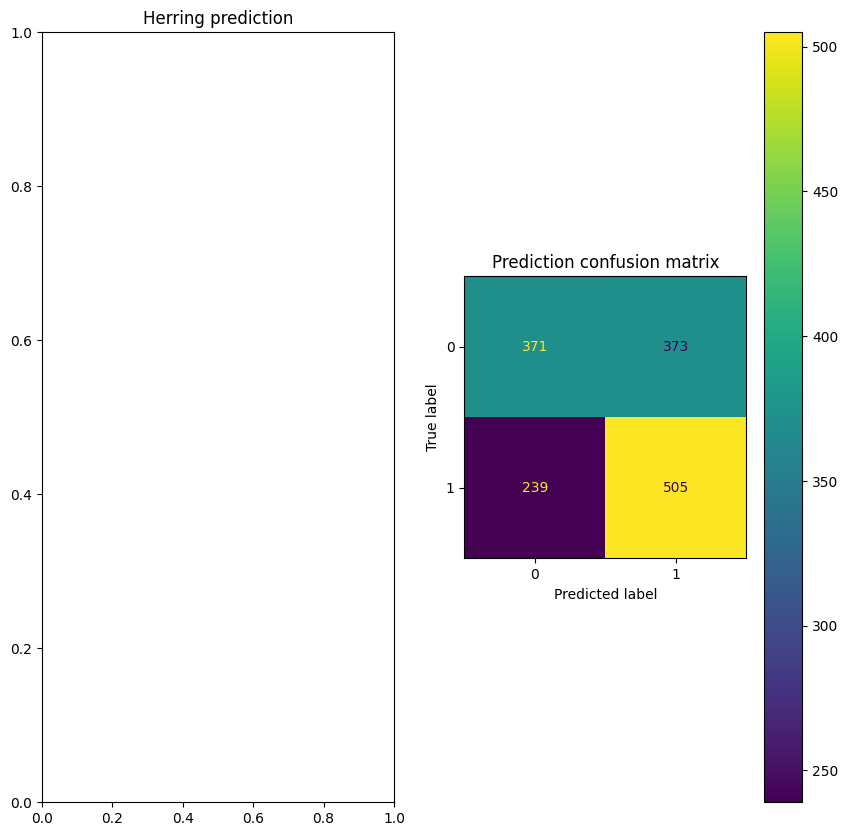

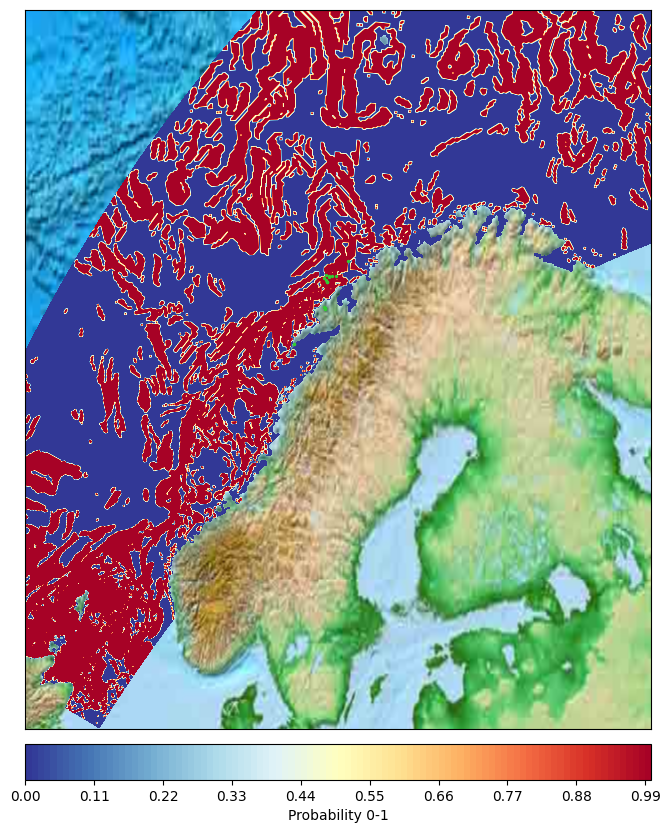

Validation metrics for model:  <class '__main__.simpleNet'>
583420
(1488,) (1488,)
Sensitivity:  0.5309139784946236  Specificity:  0.7163978494623656  Accuracy:  0.6236559139784946
Amount of correct predictions on given day:  0.0


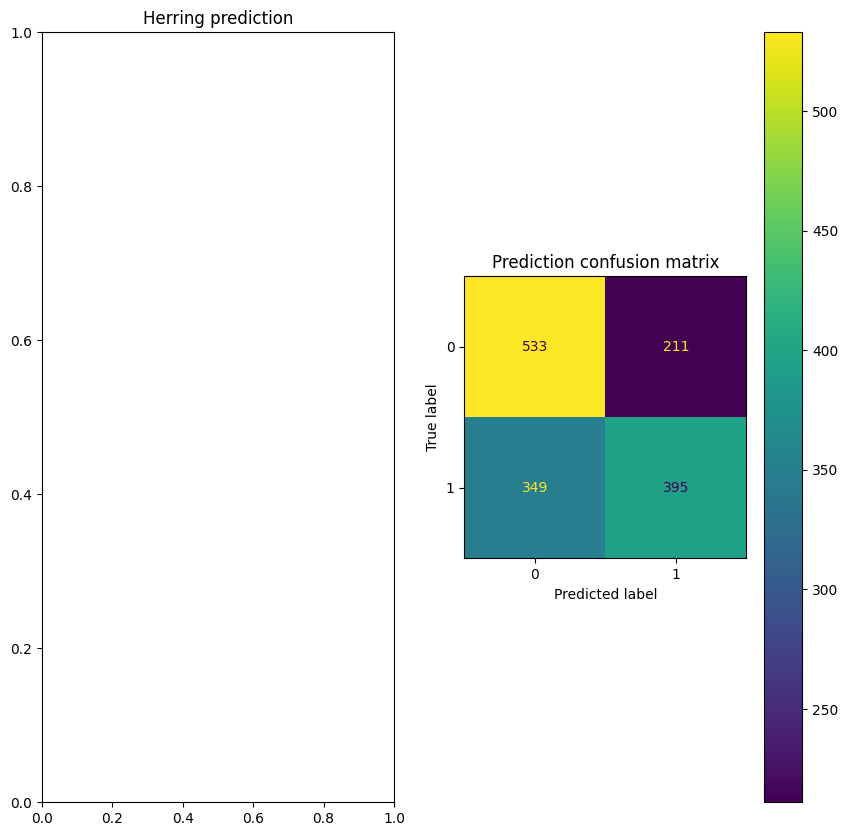

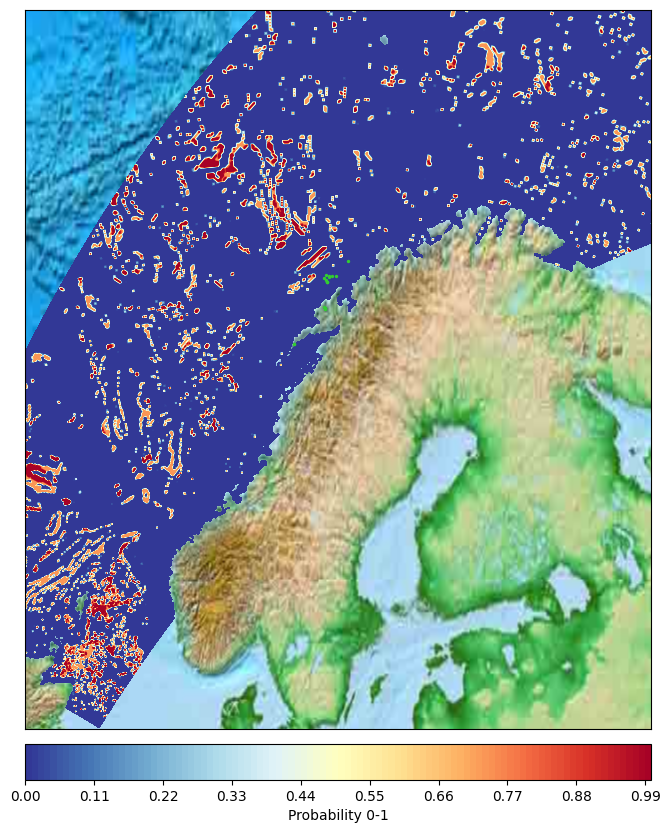

Validation metrics for model:  <class 'h2o.estimators.random_forest.H2ORandomForestEstimator'>
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
583420
(1488, 1) (1488,)
Sensitivity:  0.7446236559139785  Specificity:  0.6196236559139785  Accuracy:  0.6821236559139785
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████

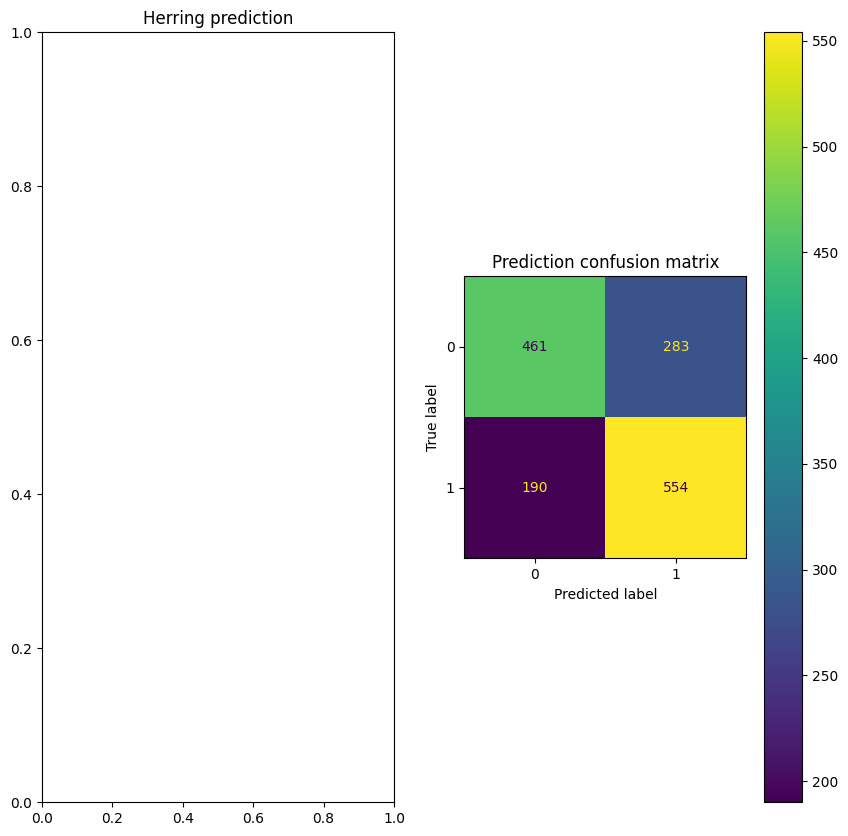

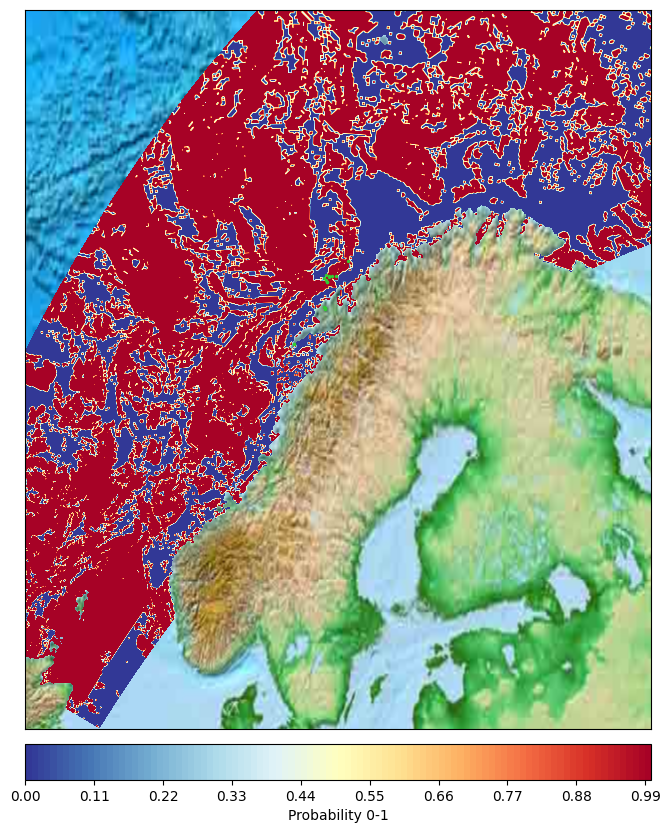

In [5]:
#h2o.shutdown()
h2o.init()

#X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(jan, jan_target, test_size = .3)
test_partition(all_data_except_jan_2021, jan_2021_data, all_targets_except_jan_2021, jan_2021_target, True)

In [ ]:
#h2o.shutdown()
#h2o.init()
models = (lin, NN, drf)
validate_models(models, X_test, Y_test,cutoff = .5, show_plot=False)

<h2> Testing of dataset partitions </h2>
Now that the optimal dataset is found, it is time to test for the optimal dataset partitions. These are described in the report.

First up is randomized set with randomized partition:

In [12]:
folder = 'dataset_2_skip_bad_cells'
jan_2019_data, jan_2019_target = ut.load_and_combine_data(2019, 'jan',folder)
jan_2020_data, jan_2020_target = ut.load_and_combine_data(2020, 'jan',folder)
jan_2021_data, jan_2021_target = ut.load_and_combine_data(2021, 'jan',folder)
dec_2020_data, dec_2020_target = ut.load_and_combine_data(2020, 'dec','dataset_2_skip_bad_cells')
dec_2019_data, dec_2019_target = ut.load_and_combine_data(2019, 'dec','dataset_2_skip_bad_cells')
dec_2021_data, dec_2021_target = ut.load_and_combine_data(2021, 'dec','dataset_2_skip_bad_cells')


In [ ]:
test_partition

In [19]:
#h2o.shutdown()
#h2o.init()
all_data = np.concatenate((jan_2019_data,dec_2019_data, jan_2020_data, dec_2020_data, jan_2021_data, dec_2021_data), axis=0)
all_target = np.concatenate((jan_2019_target, dec_2019_target, jan_2020_target,dec_2020_target, jan_2021_target, dec_2021_target),axis=0)
all_target = np.array([1 if item > 0 else 0 for item in all_target]) #create classification problem
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(all_data, all_target, test_size = .5)
#X_train, Y_train = sc.fit_transform(np.random.rand(10000,16)),  np.array([1 if item > .5 else 0 for item in np.random.rand(10000)])
#test_partition(X_train, X_test, Y_train, Y_test, False)

Then, use january to predict january:

In [ ]:
h2o.shutdown()
h2o.init()

test_partition(X_train=jan_2019_data, X_test=jan_2020_data, Y_train=jan_2019_target, Y_test=jan_2020_target)
test_partition(X_train= jan_2020_data, X_test=jan_2021_data , Y_train=jan_2020_target , Y_test=jan_2021_target )

Use december to predict following december:

In [ ]:
h2o.shutdown()
h2o.init()
h2o.no_progress()
test_partition(X_train=dec_2019_data, X_test=dec_2020_data, Y_train=dec_2019_target, Y_test=dec_2020_target)
test_partition(X_train= dec_2020_data, X_test=dec_2021_data , Y_train=dec_2020_target , Y_test=dec_2021_target )

Use december to predict following january:

In [ ]:
h2o.shutdown()
h2o.init()
test_partition(X_train=dec_2019_data, X_test=jan_2020_data, Y_train=dec_2019_target, Y_test = jan_2020_target)
test_partition(X_train=dec_2020_data, X_test=jan_2021_data, Y_train=dec_2020_target, Y_test = jan_2021_target)

Use all decembers to predict all januaries:

In [13]:
all_decembers_data = np.concatenate((dec_2019_data, dec_2020_data, dec_2021_data), axis=0)
all_decembers_target = np.concatenate((dec_2019_target, dec_2020_target, dec_2021_target), axis=0)
all_januaries_data = np.concatenate((jan_2019_data, jan_2020_data, jan_2021_data), axis=0)
all_januaries_target = np.concatenate((jan_2019_target, jan_2020_target, jan_2021_target), axis=0)
#h2o.shutdown()
#h2o.init()
#test_partition(X_train=all_decembers_data, X_test=all_januaries_data, Y_train=all_decembers_target, Y_test=all_januaries_target, show_plot=True)

In [24]:
import netCDF4
column_names = ['Temperature',  'Salinity', 'u_east', 'v_north',  'w_north', 'w_east', 'depth' ,'Temperature gradient', \
     'Salinity gradient','w_east_gradient', 'u_east gradient','v_north_gradient','w_north_gradient','depth_gradient','Calanus finmarchicus', \
        'Calanus finmarchicus gradient', 'Catch']
print(len(column_names))
XC_LOW = 41 #41
YC_LOW = 157 # 157
XC_HIGH = 671# 671
YC_HIGH = 373 #
FILL_VALUE = -32767
#model = torch.load('pytorch_model')
VARIABLES = ['temperature','salinity','u_east', 'v_north',  'w_north', 'w_east', 'depth']
nc = netCDF4.Dataset(ut.localize_nc_file('nor4km_data',2021, 1,20 ))
data = ut.get_relevant_data_nc(nc,VARIABLES,12)
plankton = netCDF4.Dataset(ut.localize_plankton_file('plankton_data', 2021, 1, 20))['Calanus_finmarchicus'][...]
masked = np.ma.masked_values(data, FILL_VALUE)
masked = np.ma.masked_values(masked,  9.96921e+36)
data = ut.calculate_and_append_grads(masked)
plankton = ut.calculate_and_append_grads(plankton)
data = np.append(data, plankton, axis = 0)
data = np.ma.masked_values(data, -32767)
data =np.ma.masked_values(data, 9.96921e+36)
for i in range(data.shape[0]):
    m = data[i,...].mean()
    std = data[i,...].var()
    data[i,...] = (   data[i,...]- m)/std
for i in range(0):
    ut.print_on_map(data[i,...], title=names[i], normalize=False)
#h2o.shutdown()
h2o.init()
def _convert_h2oframe_to_numeric(h2o_frame, training_columns):
    for column in training_columns:
        h2o_frame[column] = h2o_frame[column].asnumeric()
    return h2o_frame
all_target = np.array([1 if i > 0 else 0 for i in all_target])
all_data = sc.fit_transform(all_decembers_data)
lin, NN, drf = get_models(all_data, all_target,all_decembers_data.shape[1],verbose=True)
#for i in range(YC_LOW,YC_HIGH):
  #  frame = h2o.H2OFrame(data[:,i,XC_LOW:XC_HIGH].T, column_names = column_names[:-1])
  #  print(frame['Temperature'].dtype)
   # pred = drf.predict(frame)
pred = np.array( [drf.predict(_convert_h2oframe_to_numeric(h2o.H2OFrame(data[:,i,XC_LOW:XC_HIGH].T, column_names = column_names),column_names[:-1])).as_data_frame().to_numpy() for i in range(YC_LOW,YC_HIGH)])


17
583420
Checking whether there is an H2O instance running at http://localhost:54321 .

KeyboardInterrupt: 

(216, 630, 3)
0.0 0.1423694480631229


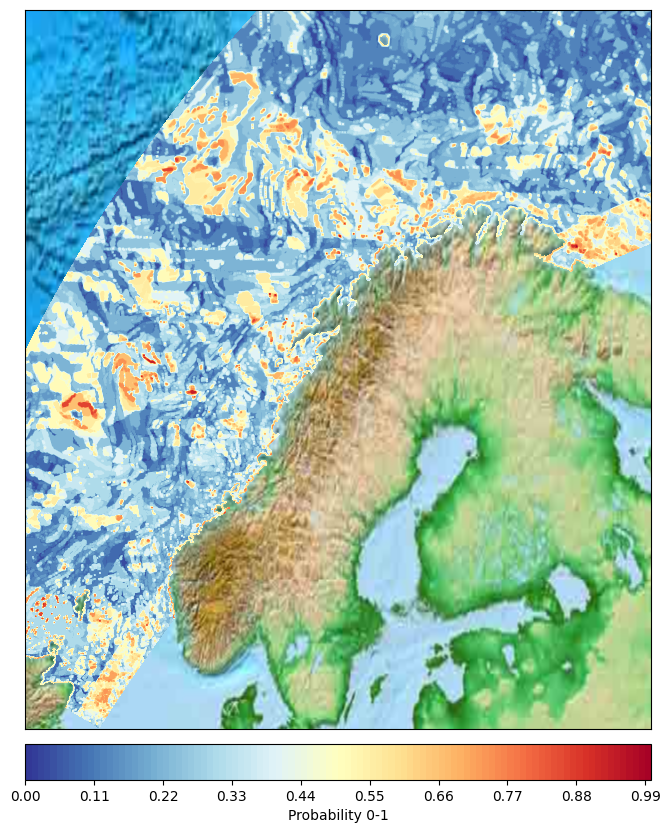

In [23]:
print(pred.shape)
_pred = np.zeros((620, 941,3))
_pred[YC_LOW:YC_HIGH, XC_LOW:XC_HIGH, :] = pred

ut.print_on_map(_pred[...,2],normalize=True)

Use half of each month to predict next half:

In [ ]:
h2o.shutdown()
h2o.init()
data = [jan_2019_data, dec_2019_data, jan_2020_data, dec_2020_data, jan_2021_data, dec_2021_data]
target = [jan_2019_target, dec_2019_target, jan_2020_target, dec_2020_target, jan_2021_target, dec_2021_target]
results = []
for i in range(len(data)):
    half = len(data[i]) //2
    print(half)
    d = data[i]
    t = target[i]
    test_partition(X_train=d[:half, :], X_test=d[half:, :], Y_train=t[:half], Y_test=t[half:])

In [ ]:
import numpy as np
linsens  = np.array([ .37, .35, .6, .63, .55, .53])
linspec = np.array([.54, .56, .57, .55, .59, .57 ])
linacc = np.array([.47, .45, .58, .58 ,.58, .55 ])

nnsens = np.array([.4, .37, .34, .34, .49, .37])
nnspec = np.array([.68, .69, .67, .63, .68, .72])
nnacc = np.array([.54, .53, .5, .48, .58, .54])

drfsens = np.array([.34, .6, .47, .63, .57, .63])
drfspec = np.array([.79, .55, .59, .5, .55, .46])
drfacc = np.array([.56, .57, .54, .56, .56, .54]  )
arr = [linsens, linspec, linacc, nnsens, nnspec, nnacc, drfsens, drfspec, drfacc]

In [ ]:

for i in range(len(data)):
    half = len(data[i]) //2
    print(half)
    d = data[i]
    t = target[i]
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(d,t, test_size=.3)
    test_partition(X_train, X_test, Y_train, Y_test)

In [ ]:
linsens  =np.array([.52, .52, .68, .67, .63, .67 ])
linspec = np.array([.52, .53, .52, .54, .53, .57 ])
linacc = np.array([.52, .53, .6, .6, .58, .62, ])

nnsens = np.array([.79, .73 , .74, .65, .67, .71])
nnspec = np.array([.66, .72, .7, .71, .72, .77])
nnacc = np.array([.73 , .73, .72, .68, .69, .74])

drfsens = np.array([.83, .8, .86, .82, .87, .91])
drfspec = np.array([.64, .64, .55 , .55, .6, .47])
drfacc = np.array([.73, .72, .7, .68, .73, .69]  )
arr = [linsens, linspec, linacc, nnsens, nnspec, nnacc, drfsens, drfspec, drfacc]

In [ ]:
for i in arr:
    print(i.mean(), i.var())